In [1]:
import torch
import torch.nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
from copy import deepcopy

/Users/silverstar/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/__init__.py:17: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  from scipy.sparse import issparse


In [2]:
train_rawdata = datasets.MNIST(root = 'data', # 경로 의미하는 것임
                               train=True, # 참 -> 트레인 데이터, 거짓 ->  테스트데이터 줌
                               download=True, # 다운
                               transform = transforms.ToTensor()) # 텐서로 바꿔
test_dataset = datasets.MNIST(root = 'dataset',
                               train=False,
                               download=True,
                               transform = transforms.ToTensor)
print('number of training data: ', len(train_rawdata))
print('number of test data: ', len(test_dataset))

number of training data:  60000
number of test data:  10000


In [3]:
VALIDATION_RATE = 0.2
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_rawdata)), # x index번호
    train_rawdata.targets, # y
    stratify = train_rawdata.targets,
    test_size=VALIDATION_RATE
)

In [4]:
train_dataset = Subset(train_rawdata, train_indices) # 주어진 인덱스에 해당하는 것만 가져온다.
# train_rawdata 는 train 의 전체 데이터
# 여기서 train과 val로 나눴으니 새로운 train 들을 선택해야 함
# 그래서 Subset을 이용함
validation_dataset = Subset(train_rawdata, val_indices)

In [5]:
# 데이터셋 확인
print( len (train_dataset), len(validation_dataset), len(test_dataset))

48000 12000 10000


In [6]:
# 미니배치 
batch_size = 128
train_batches = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batches = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
x_train, y_train = next(iter(train_batches)) # 하나만 가져와서 모양 보기
print(x_train.shape, y_train.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [8]:
# x_train[index, :, :, :].shape

In [9]:
# x_train[index, :, :, :].numpy().reshape(28, 28).shape

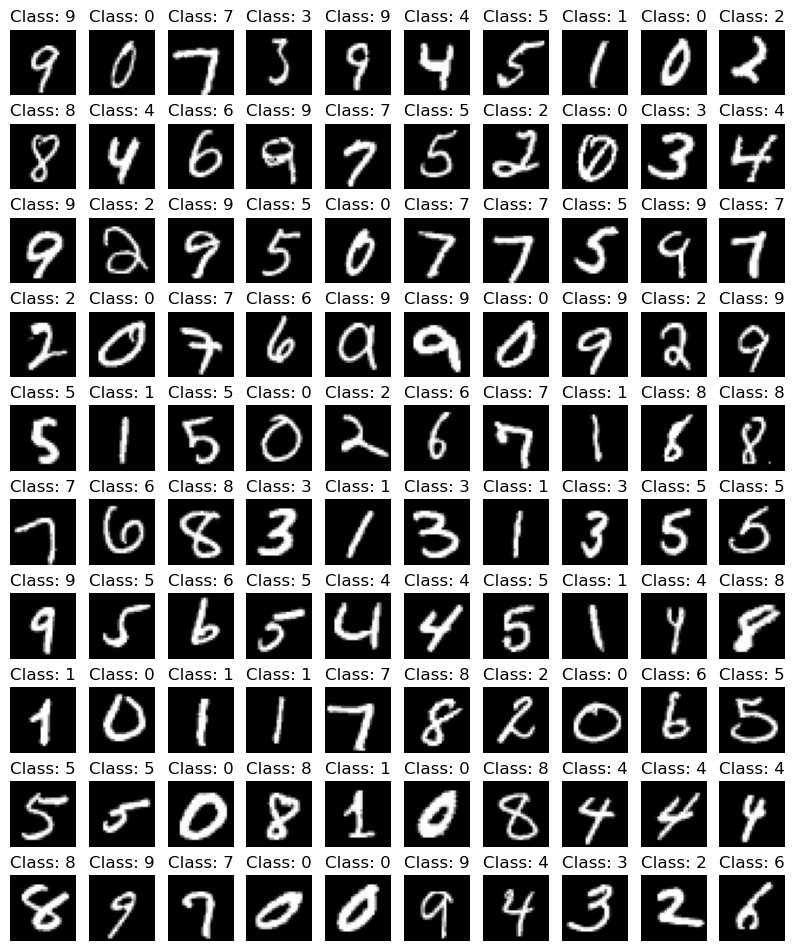

In [10]:
# %matplotlib inline

plt.figure(figsize=(10,12))

for index in range(100):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(x_train[index,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: ' + str(y_train[index].item()))

In [11]:
# 미니배치 하나만 가져와서 이미지 visualization
x_train, y_train = next(iter(train_batches))
print(x_train.shape, y_train.shape)
print(x_train.size(0))
print(x_train.view(x_train.size(0), -1).shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])
128
torch.Size([128, 784])


In [12]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0, 1),
            nn.Linear(256,256),
            nn.LeakyReLU(0, 1),
            nn.Linear(256,128),
            nn.LeakyReLU(0,1),
            nn.Linear(128, output_dim),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        y = self.linear_layers(x)
        return y
        

In [13]:
minibatch_size = 128
input_dim = 28*28
output_dim = 10
model = Model(input_dim, output_dim)

loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
# saving best model
# model.stat_dict() : 사전 객체로 추출이 가능하다
# model.load_state_dict(x) : model.stat_dict() 에 저장된 매개변수를 가져올 수 있다.

In [15]:
from copy import deepcopy

In [19]:
def train_model(model, early_stop, n_epochs, progress_interval):
    
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf
    
    for epoch in range(n_epochs):
        
        train_loss, valid_loss = 0, 0
        
        # train the model
        model.train()
        for x_minibatch, y_minibatch in train_batches:
            y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
            loss = loss_func(y_minibatch_pred, y_minibatch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        train_loss = train_loss / len(train_batches)
        train_losses.append(train_loss)
        
        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_batches:
                y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
                
        valid_loss = valid_loss / len(val_batches)
        valid_losses.append(valid_loss)
        
        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch:
                print("early stopped" , epoch, "epochs")
                break
        
        if(epoch % progress_interval) == 0:
            print(train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)
            
    model.load_state_dict(best_model)
    return model, lowest_loss, train_losses, valid_losses
            

In [22]:
nb_epochs = 30
progress_interval = 3
early_stop = 5

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.03188769582659006 0.09749148594601913 0.09749148594601913 0 0
0.016561645727294187 0.10655475638626005 0.08920184249415043 1 3
0.014346079063873427 0.11373481751875357 0.08920184249415043 1 6
early stopped 7 epochs


In [23]:
valid_losses

[0.09749148594601913,
 0.08920184249415043,
 0.11172978534422656,
 0.10655475638626005,
 0.11392571395163999,
 0.13529428974598365,
 0.11373481751875357,
 0.12289583688958529]